<a href="https://colab.research.google.com/github/juanluserra/master_bigdata/blob/main/BASES%20DE%20DATOS/Practicas/neo4j/practica7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoSQL (Neo4j) (sesión 7)

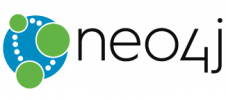

Esta hoja muestra cómo acceder a bases de datos Neo4j y también a conectar la salida con Google Colab/Jupyter:

In [1]:
!sudo apt update -qq
!sudo apt install -qq -y apt-transport-https ca-certificates curl software-properties-common p7zip

53 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
p7zip is already the newest version (16.02+dfsg-8).
p7zip set to manually installed.
ca-certificates is already the newest version (20240203~22.04.1).
curl is already the newest version (7.81.0-1ubuntu1.20).
software-properties-common is already the newest version (0.99.22.9).
The following NEW packages will be installed:
  apt-transport-https
0 upgraded, 1 newly installed, 0 to remove and 53 not upgraded.
Need to get 1,510 B of archives.
After this operation, 170 kB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling

In [2]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [3]:
%%capture URL_output
if RunningInCOLAB:
    !curl -fsSL https://debian.neo4j.com/neotechnology.gpg.key | sudo apt-key add -
    !sudo add-apt-repository -y "deb https://debian.neo4j.com stable latest"
    !sudo apt install --reinstall -qq neo4j
    !grep -q -e '^# Updated' /etc/neo4j/neo4j.conf || \
      sudo sed -i -e '1s/^/db.import.csv.legacy_quote_escaping=false\n/;1s/^/dbms.security.auth_enabled=false\n/;1s/^/server.memory.heap.initial_size=8G\n/;1s/^/server.memory.heap.max_size=8G\n/;1s/^/# Updated config\n/' /etc/neo4j/neo4j.conf
    !head /etc/neo4j/neo4j.config
    !sudo neo4j start
    !wget http://dsevilla-proxy.inf.um.es/frp-neo4j -qq -O frpc.ini
    !wget -qq "https://github.com/fatedier/frp/releases/download/v0.52.3/frp_0.52.3_linux_amd64.tar.gz"
    !tar zxf frp_*
    !./frp_*/frpc -c frpc.ini >/dev/null 2>&1 &
    !grep ^remote_port frpc.ini | sed -e '1s/remote_port = /http:\/\/dsevilla-proxy.inf.um.es:/;2s/remote_port = /bolt:\/\/dsevilla-proxy.inf.um.es:/'

In [4]:
if RunningInCOLAB:
  print(URL_output)

OK
Repository: 'deb https://debian.neo4j.com stable latest'
Description:
Archive for codename: stable components: latest
More info: https://debian.neo4j.com
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/archive_uri-https_debian_neo4j_com-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/archive_uri-https_debian_neo4j_com-jammy.list
Get:1 https://debian.neo4j.com stable InRelease [44.3 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://debian.neo4j.com stable/latest amd64 Packages [10.6 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadc

In [63]:
import os
BOLT_URL: str = f"bolt://{os.getenv('DB_HOSTNAME', 'localhost')}:7687"
if RunningInCOLAB:
  BOLT_URL = URL_output.stdout.split(os.linesep)[-2]
  HTTP_URL: str = URL_output.stdout.split(os.linesep)[-3]
  print(f"URL de conexión de BOLT:\n{BOLT_URL}")
  print(f"URL de conexión al interfaz Web:\n{HTTP_URL}")

URL de conexión de BOLT:
bolt://dsevilla-proxy.inf.um.es:8159
URL de conexión al interfaz Web:
http://dsevilla-proxy.inf.um.es:8158


In [6]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [7]:
%pip install neo4j-driver pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.4 MB/s eta 0:00:00
  Created wheel for neo4j-driver: filename=neo4j_driver-5.27.0-py3-none-any.whl size=301902 sha256=5f7608b6346a631502f8928189d7991554c6e5eb62670f8f471236f94c6a6722
  Stored in directory: /root/.cache/pip/wheels/97/9c/63/9b5a51b678fce6807d92992ffa75382bacc8df2a5016efc986
Successfully built neo4j-driver


Conexión a la Base de Datos


In [8]:
from neo4j import Driver, GraphDatabase, Session, Result, basic_auth

driver: Driver = GraphDatabase.driver(
    BOLT_URL,
    auth=basic_auth("neo4j", ""))
session: Session = driver.session()

cypher_query = '''
MATCH (n)
RETURN n AS id
LIMIT 10
'''

results: Result = session.run(cypher_query,  parameters={})

for record in results:
  print(record['id'])

La siguiente celda genera una consulta en Cypher que devuelve los 10 primeros nodos. Al inicio la base de datos está vacía, pero se puede probar después para ver la salida. Existen plugins para ver gráficamente la salida como un grafo, pero para eso usaremos el interfaz gráfico del propio Neo4j.

In [9]:
from neo4j import Result

query = '''
MATCH (n)
RETURN n
LIMIT 10
'''

with driver.session() as session:
  results: Result = session.run(query)
  for record in results:
    print(record)

In [10]:
from collections.abc import Generator
from contextlib import contextmanager
from neo4j import Result

@contextmanager
def run_query(query) -> Generator[Result, None, None]:
  with driver.session() as session:
    yield session.run(query)

La carga de datos CSV no se podía realizar directamente desde los ficheros CSV la hoja, porque el CSV que acepta Neo4j no es estándar. Envié un *issue* para que lo arreglaran, y en la versión 3.3 parece que ya funciona si se añade un parámetro de configuración: https://github.com/neo4j/neo4j/issues/8472

```bash
dbms.import.csv.legacy_quote_escaping = false
```

He añadido al contenedor de la práctica esta opción en la carga de Neo4j. Tened en cuenta que si usáis otra configuración hay que añadírselo.

Primero se crea un índice sobre el atributo `Id` de `User`, que se usará después para crear usuarios y relacionarlos con la pregunta o respuesta que se ha leído. Si no se hace esto, la carga del CSV es muy lenta.

In [11]:
with run_query("CREATE INDEX IF NOT EXISTS FOR (u:User) ON (u.Id);") as _:
    pass

El siguiente código carga el CSV de las preguntas y respuestas. El código primero todos los nodos con la etiqueta `Post`, y después añade la etiqueta `Question` ó `Answer` dependiendo del valor del atributo `PostTypeId`.

In [12]:
%%sh
(wget -qq https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001 -O -;
 wget -qq https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002 -O -) > es.stackoverflow.csv.7z

In [13]:
!7zr x es.stackoverflow.csv.7z
!rm -rf es.stackoverflow.csv.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 200457538 bytes (192 MiB)

Extracting archive: es.stackoverflow.csv.7z
--
Path = es.stackoverflow.csv.7z
Type = 7z
Physical Size = 200457538
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% - Comments.csv                     1% - Comments.csv                     2% - Comments.csv                     3% - Comments.csv                     4% - Comments.csv                     5% - Comments.csv                     6% - Comments.csv           

Si se ejecuta dentro de Google Colab, el servidor Neo4j está ejecutándose en la misma máquina, por lo que hay que copiar el fichero CSV al directorio donde el servidor Neo4j es capaz de importarlo. En este caso, el directorio es `/var/lib/neo4j/import/`. (El otro caso lo añado para pruebas internas o para cuando la hoja se ejecuta en un entorno con Docker con el fichero `docker-compose.yml` dado).

In [14]:
if RunningInCOLAB:
    !sudo ln Posts.csv /var/lib/neo4j/import/
else:
    !test -e /tmp/neo4j_import || mkdir /tmp/neo4j_import
    !sudo cp Posts.csv /tmp/neo4j_import/

### El lenguaje Cypher

El lenguaje Cypher tiene una sintaxis de _Query By Example_. Acepta funciones y permite creación y búsqueda de nodos y relaciones. Tiene algunas peculiaridades que veremos a continuación. Por lo pronto, se puede ver un resumen de características en la [Cypher Reference Card](https://neo4j.com/docs/cypher-refcard/current/).

La anterior consulta utiliza la construcción `LOAD CSV` para leer datos CSV dentro de nodos. La cláusula `CREATE` crea nuevos nodos. La `SET` permite poner valores a las propiedades de los nodos.

En el caso de la consulta de arriba, a todos los datos leídos se les copia los datos de la línea (primer `SET`). Después, dependiendo del valor de `PostTypeId`, se les etiqueta como `:Question` o como `:Answer`. Si tienen un usuario asignado a través de `OwnerUserId`, se añade un usuario si no existe y se crea la relación `:WROTE`.

También hay otros posts especiales que no eran preguntas ni respuestas. A estos no se les asigna una segunda etiqueta:

In [15]:
with run_query(
        '''
        LOAD CSV WITH HEADERS from "file:///Posts.csv" AS row
        CALL (row) {
            CREATE (n)
            SET n = row
            SET n :Post
        } IN TRANSACTIONS OF 10000 ROWS
        ;
        '''
        ) as result:
    print(result.consume().counters)

{'_contains_updates': True, 'labels_added': 410346, 'nodes_created': 410346, 'properties_set': 9027094}


### OJO:
Para borrar la base de datos entera, por si se cometen errores:

    query = "CALL { MATCH (n) DETACH DELETE n } IN TRANSACTIONS OF 10000 ROWS"
    run_query(query)

In [16]:
def clear_database() -> None:
  """
  Eliminar la base de datos completamente.
  """
  query = "CALL { MATCH (n) DETACH DELETE n } IN TRANSACTIONS OF 10000 ROWS"
  with run_query(query) as _:
    pass

A todas las preguntas, se las etiqueta con `Question`.

In [17]:
with run_query('''
      MATCH (n:Post {PostTypeId : "1"})
        SET n:Question;
      ''') as _:
    pass

A todas las respuestas se las etiqueta con `Answer`.

In [18]:
with run_query('''
      MATCH (n:Post {PostTypeId : "2"})
        SET n:Answer;
      ''') as _:
    pass

Se crea un nodo usuario (o se utiliza uno si ya existe) usando el campo `OwnerUserId`, siempre que no esté vacío. Nótese que se puede utilizar `CREATE` porque esta combinación de relación usuario y pregunta no existe. Cuidado, si se ejecuta dos veces creará el doble de relaciones. Se aprovecha para añadir una característica a la propia relación, la fecha de creación de la pregunta por parte del usuario.

In [19]:
with run_query(
            '''
            MATCH (n:Post)
            WHERE n.OwnerUserId <> ""
                MERGE (u:User {Id: n.OwnerUserId})
                CREATE (u)-[:WROTE {CreationDate: n.CreationDate}]->(n);
            '''
            ) as _:
    pass

In [20]:
import pyvis
from IPython.display import display, HTML

def visualize_result(query_graph, nodes_text_properties):
    visual_graph = pyvis.network.Network(notebook=True,cdn_resources='in_line')

    for node in query_graph.nodes:
        node_label = list(node.labels)[0]
        node_text = node[nodes_text_properties[node_label]]
        visual_graph.add_node(node.element_id, node_text, group=node_label)

    for relationship in query_graph.relationships:
        visual_graph.add_edge(
            relationship.start_node.element_id,
            relationship.end_node.element_id,
            title=relationship.type
        )

    visual_graph.show('example.html')
    display(HTML('example.html'))

nodes_text_properties = {  # what property to use as text for each node
            "Post": "Title",
            "Question": 'Title',
            "Answer": 'Body',
            "User": 'Id'
}

In [21]:
query = \
'''
match r=(u:User)-[:WROTE]->(p:Post) RETURN r LIMIT 20
'''

with driver.session() as session:
  result = session.run(query)
  visualize_result(result.graph(), nodes_text_properties)


example.html


Creamos un índice sobre el `Id` para acelerar las siguientes búsquedas:

In [22]:
with run_query("CREATE INDEX IF NOT EXISTS FOR (n:Post) ON (n.Id);") as _:
    pass

Añadimos una relación entre las preguntas y las respuestas:

In [23]:
with run_query('''
        MATCH (a:Answer), (q:Question {Id: a.ParentId})
        CREATE (a)-[:ANSWERS]->(q)
        ''') as _:
    pass

Las construcciones `%cypher` retornan resultados de los que se puede obtener un `dataframe` de `pandas`:

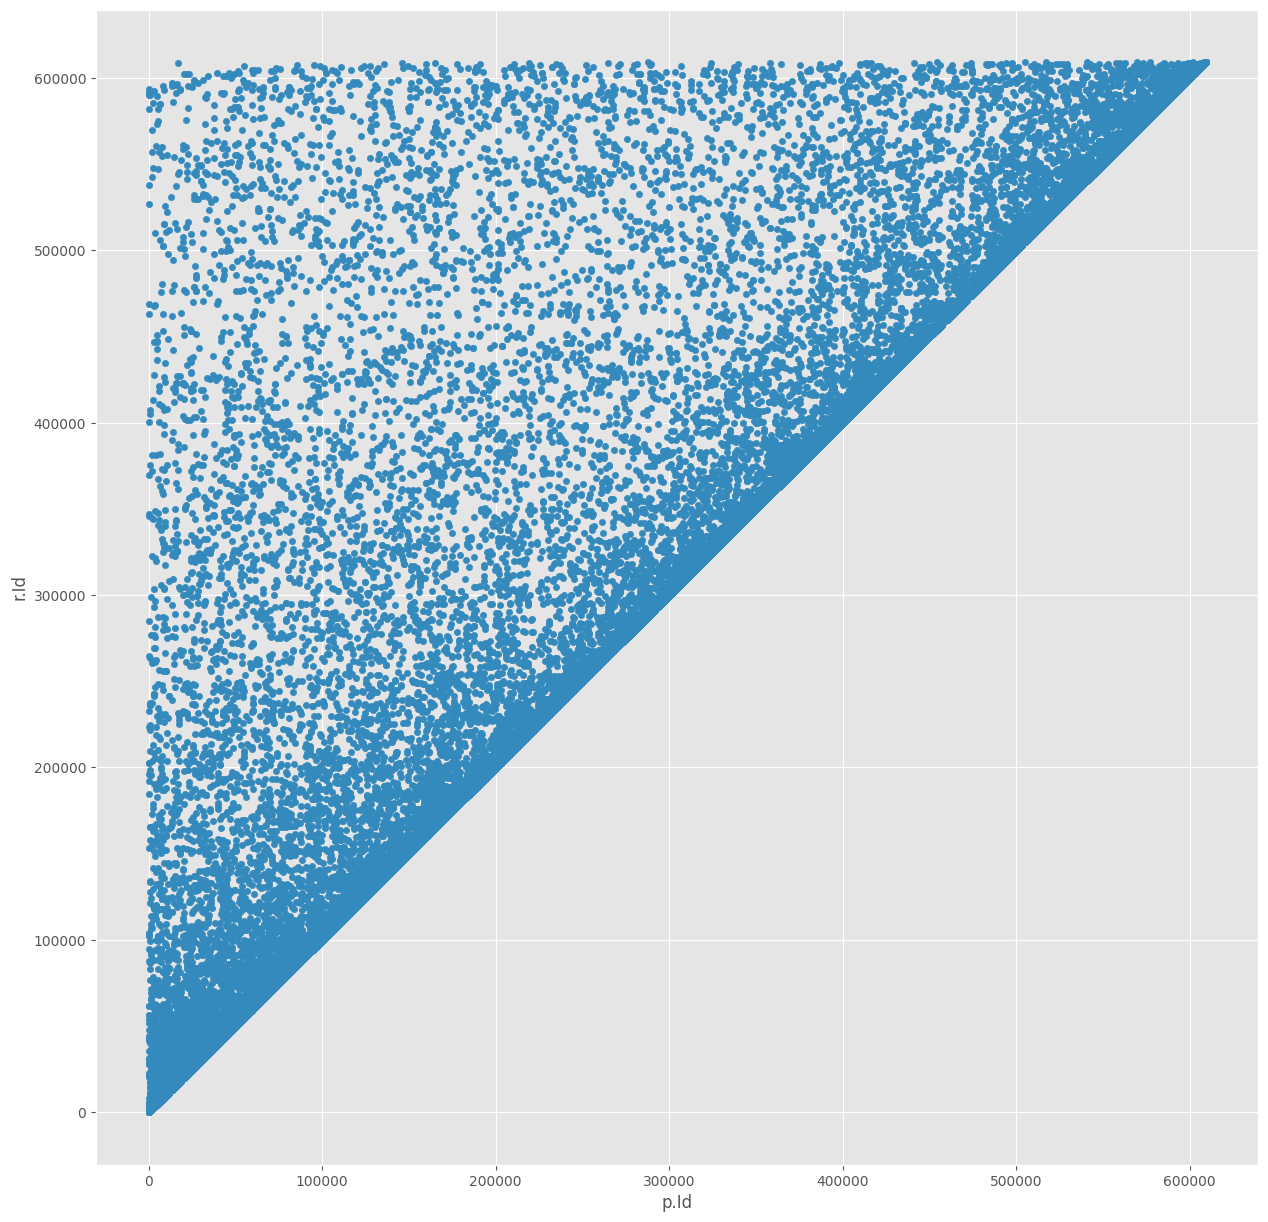

In [24]:
query="MATCH q=(r)-[:ANSWERS]->(p) RETURN p.Id,r.Id;"

with driver.session() as session:
  res: Result = session.run(query)
  df = pd.DataFrame([r.values() for r in res], columns=res.keys())
  df['r.Id'] = pd.to_numeric(df['r.Id'],downcast='unsigned')
  df['p.Id'] = pd.to_numeric(df['p.Id'],downcast='unsigned')

  df.plot(kind='scatter',x='p.Id',y='r.Id',figsize=(15,15))

La consulta de reciprocidad entre usuarios de Stackoverflow se puede resolver de manera muy fácil. En esta primera consulta se devuelve los nodos:

In [25]:
query='''// RQ4
MATCH
(u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
(u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND u1.Id < u2.Id
RETURN DISTINCT u1,u2
'''

with run_query(query) as res:
  for r in res:
    print(r['u1'], r['u2'])

<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410627' labels=frozenset({'User'}) properties={'Id': '1184'}> <Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410347' labels=frozenset({'User'}) properties={'Id': '21'}>
<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410669' labels=frozenset({'User'}) properties={'Id': '2230'}> <Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410348' labels=frozenset({'User'}) properties={'Id': '24'}>
<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:414807' labels=frozenset({'User'}) properties={'Id': '19610'}> <Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410348' labels=frozenset({'User'}) properties={'Id': '24'}>
<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410348' labels=frozenset({'User'}) properties={'Id': '24'}> <Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410349' labels=frozenset({'User'}) properties={'Id': '25'}>
<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:

O bien retornar los `Id` de cada usuario:

In [26]:
query = '''
MATCH
(u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
(u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND toInteger(u1.Id) < toInteger(u2.Id)
RETURN DISTINCT u1.Id,u2.Id
ORDER BY toInteger(u1.Id)
'''

with run_query(query) as res:
  for r in res:
    print(r['u1.Id'], r['u2.Id'])

21 1184
22 342
22 729
22 288
23 25
24 25
24 95
24 301
24 463
24 2230
24 19610
24 32772
25 225
25 288
34 250
65 78
65 1184
65 7661
73 250
73 2224
73 6497
73 9897
73 29967
78 250
83 100
83 301
83 29967
83 224441
95 250
95 29967
95 131982
100 187
100 399
100 529
100 638
100 729
100 353
100 2004
100 2838
120 531
127 29967
154 13938
184 16597
191 2230
250 399
250 729
250 731
250 6491
250 2163
250 2230
250 2429
250 9897
250 12625
250 14243
250 324
250 13938
250 10576
250 16597
250 18597
250 19610
250 27297
250 27881
250 29967
301 2230
342 517
342 2367
342 29967
342 112975
398 547
398 2171
399 555
463 2742
463 19600
517 2676
535 2230
638 29967
638 35232
729 1798
729 1839
729 2224
729 6095
2004 2747
2163 2230
2230 22112
2230 4684
2230 5902
2230 12446
2230 16108
2366 5324
2429 6491
2429 29967
2676 29967
2742 19610
2832 6497
3275 35873
3440 6491
4229 29967
5808 21775
6095 13938
6095 19610
6491 10576
6491 18771
6491 23233
6491 29967
6491 34430
6974 29967
7123 31764
7123 180118
9874 19919
9885 161

Y finalmente, la creación de relaciones `:RECIPROCATE` entre los usuarios. Se introduce también la construcción `WITH`.

`WITH` sirve para introducir "espacios de nombres". Permite importar nombres de filas anteriores, hacer alias con `AS` e introducir nuevos valores con funciones de Cypher. La siguiente consulta es la misma de arriba, RQ4, pero creando relaciones `:RECIPROCATE` entre cada dos usuarios que se ayudan recíprocamente.

In [27]:
query='''
// RQ4 creando relaciones de reciprocidad
MATCH
  (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
  (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND u1.Id < u2.Id
WITH u1 AS user1,u2 AS user2
  MERGE (user1)-[:RECIPROCATE]->(user2)
  MERGE (user2)-[:RECIPROCATE]->(user1)
'''

with run_query(query) as res:
  for r in res:
    print(r)

También se puede buscar el camino mínimo entre dos usuarios cualesquiera. Si existe un camino a través de alguna pregunta o respuesta, la encontrará. Un ejemplo donde hay una comunicación directa:

In [28]:
query = "MATCH p=shortestPath( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p"

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r['p'])

with driver.session() as session:
  result: Result = session.run(query)
  visualize_result(result.graph(), nodes_text_properties)

<Path start=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410348' labels=frozenset({'User'}) properties={'Id': '24'}> end=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410349' labels=frozenset({'User'}) properties={'Id': '25'}> size=1>
example.html


Mientras que con otro usuario la cadena es más larga:

In [29]:
query="MATCH p=shortestPath( (u1:User {Id: '324'})-[*]-(u2:User {Id:'25'}) ) RETURN p"

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r['p'])

with driver.session() as session:
  result: Result = session.run(query)
  visualize_result(result.graph(), nodes_text_properties)

<Path start=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:413760' labels=frozenset({'User'}) properties={'Id': '324'}> end=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410349' labels=frozenset({'User'}) properties={'Id': '25'}> size=4>
example.html


Finalmente se pueden encontrar todos los caminos mínimos en donde se ve que tiene que existir al menos un par pregunta/respuesta entre los usuarios que son recíprocos:

In [30]:
query="MATCH p=allShortestPaths( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p"

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r['p'])

<Path start=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410348' labels=frozenset({'User'}) properties={'Id': '24'}> end=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410349' labels=frozenset({'User'}) properties={'Id': '25'}> size=1>
<Path start=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410348' labels=frozenset({'User'}) properties={'Id': '24'}> end=<Node element_id='4:a4febf4a-8a88-4899-8c68-46f025ac991e:410349' labels=frozenset({'User'}) properties={'Id': '25'}> size=1>


## EJERCICIO: Construir los nodos `:Tag` para cada uno de los tags que aparecen en las preguntas. Construir las relaciones `post-[:TAGGED_BY]->tag` para cada tag y también `tag-[:TAGS]->post`

(**OJO**: Hay que crear un índice antes para `Tag.name`, si no el proceso es muy lento)

Para ello, buscar en la ayuda las construcciones `WITH` y `UNWIND` y las funciones `replace()` y `split()` de Cypher. La siguiente consulta debe retornar 26135 resultados:

In [41]:
query='''
MATCH p=(t:Tag)-[:TAGS]->(:Question) WHERE t.name =~ "^java$|^c\\\\+\\\\+$" RETURN count(p);
'''

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

<Record count(p)=0>


La siguiente consulta muestra los usuarios que preguntan por cada Tag:

In [32]:
query="MATCH (t:Tag)-->(:Question)<--(u:User) RETURN t.name,collect(distinct u.Id) ORDER BY t.name;"

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

El mismo `MATCH` se puede usar para encontrar qué conjunto de tags ha usado cada usuario cambiando lo que retornamos:

In [33]:
query="MATCH (t:Tag)-->(:Question)<--(u:User) RETURN u.Id, collect(distinct t.name) ORDER BY toInteger(u.Id);"
with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

## EJERCICIO: Relacionar cada usuario con los tags de sus preguntas a través de la relación `:INTERESTED_IN` (similar a E1).

In [79]:
# Creamos índices para Tag.name
query = '''
CREATE INDEX IF NOT EXISTS FOR (t:Tag) ON (t.name);
'''

with driver.session() as session:
  res: Result = session.run(query)

In [112]:
# Hacemos un merge y create para crear los nodos
query = '''
MATCH (q:Question)
WITH SPLIT(REPLACE(q.Tags, "<", ""), ">") AS tags, q
UNWIND tags AS tag
WITH tag, q
WHERE tag <> ""
MERGE (t:Tag {name: tag})
MERGE (q)<-[:TAGS]-(t)
;
'''

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

In [124]:
# Creamos la relación entre usuarios y tags
query = """
MATCH (u:User)-[:WROTE]->(q:Question)<-[:TAGS]-(t:Tag)
MERGE (u)-[:INTERESTED_IN]->(t)
;
"""

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

In [139]:
# Probamos la eficacia de la consulta con un usuario de prueba
test_user: int = 24
query = f'MATCH (u:User)-[:INTERESTED_IN]->(t) WHERE u.Id = "{test_user}" RETURN u.Id, t.name;'

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

<Record u.Id='24' t.name='casting'>
<Record u.Id='24' t.name='java'>
<Record u.Id='24' t.name='c++11'>
<Record u.Id='24' t.name='gradle'>
<Record u.Id='24' t.name='angular2-template'>
<Record u.Id='24' t.name='terminal'>
<Record u.Id='24' t.name='angularjs-2.0'>
<Record u.Id='24' t.name='c#'>
<Record u.Id='24' t.name='android'>
<Record u.Id='24' t.name='arquitectura'>
<Record u.Id='24' t.name='string'>
<Record u.Id='24' t.name='tokens'>
<Record u.Id='24' t.name='gnu'>
<Record u.Id='24' t.name='compilador'>
<Record u.Id='24' t.name='c++'>
<Record u.Id='24' t.name='linux'>
<Record u.Id='24' t.name='vscode'>
<Record u.Id='24' t.name='c'>
<Record u.Id='24' t.name='android-studio'>


## EJERCICIO: Cargar el CSV de Users y añadir las propiedades faltantes a los usuarios (hasta ahora cada nodo `:User` sólo tiene la propiedad `Id`. Hay que cargar el resto a partir del CSV).

In [147]:
# Creamos los índices para users
query = '''
CREATE INDEX IF NOT EXISTS FOR (u:User) ON (u.Id);
'''

with driver.session() as session:
  res: Result = session.run(query)

In [140]:
# Subimos el csv de Users.csv a Neo4j
if RunningInCOLAB:
    !sudo ln Users.csv /var/lib/neo4j/import/
else:
    !test -e /tmp/neo4j_import || mkdir /tmp/neo4j_import
    !sudo cp Users.csv /tmp/neo4j_import/

In [146]:
# Actualizamos los valores de los nodos u:User
query = """
LOAD CSV WITH HEADERS from "file:///Users.csv" AS row
MATCH (u:User {Id: row.Id})
SET u += row
;
"""

with driver.session() as session:
  res: Result = session.run(query)

In [148]:
# Comprobamos que los valores están actualizados
query = 'MATCH (u:User) RETURN keys(u) LIMIT 1;'

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

<Record keys(u)=['CreationDate', 'WebsiteUrl', 'Location', 'DisplayName', 'AboutMe', 'AccountId', 'DownVotes', 'LastAccessDate', 'Id', 'Views', 'Reputation', 'UpVotes']>


## EJERCICIO: Recomendar a los usuarios _tags_ sobre los que podrían estar interesados en base a _tags_ en los que los usuarios con los que están relacionados con `:RECIPROCATE` están interesados y ellos no, ordenado por número de usuarios interesados en cada _tag_.

In [180]:
user = 29967

query = f'''
MATCH (u1:User)-[:RECIPROCATE]->(u2:User)-[:INTERESTED_IN]->(t:Tag)
WHERE NOT (u1)-[:INTERESTED_IN]->(t) AND u1.Id = "{user}"
WITH t, COUNT(DISTINCT u2) AS n_users, u1
RETURN u1.Id, t.name, n_users
ORDER BY n_users DESC
;
'''

with driver.session() as session:
  res: Result = session.run(query)
  for r in res:
    print(r)

<Record u1.Id='29967' t.name='python' n_users=11>
<Record u1.Id='29967' t.name='laravel' n_users=10>
<Record u1.Id='29967' t.name='codeigniter' n_users=9>
<Record u1.Id='29967' t.name='c#' n_users=9>
<Record u1.Id='29967' t.name='algoritmos' n_users=9>
<Record u1.Id='29967' t.name='sql-server' n_users=8>
<Record u1.Id='29967' t.name='bash' n_users=8>
<Record u1.Id='29967' t.name='xml' n_users=7>
<Record u1.Id='29967' t.name='web' n_users=7>
<Record u1.Id='29967' t.name='oracle' n_users=7>
<Record u1.Id='29967' t.name='reactjs' n_users=7>
<Record u1.Id='29967' t.name='ionic' n_users=6>
<Record u1.Id='29967' t.name='funciones' n_users=6>
<Record u1.Id='29967' t.name='ordenamiento' n_users=6>
<Record u1.Id='29967' t.name='angularjs' n_users=6>
<Record u1.Id='29967' t.name='docker' n_users=6>
<Record u1.Id='29967' t.name='npm' n_users=6>
<Record u1.Id='29967' t.name='angular' n_users=6>
<Record u1.Id='29967' t.name='python-3.x' n_users=6>
<Record u1.Id='29967' t.name='c' n_users=6>
<Record